In [1]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, XLNetForSequenceClassification, AdamW, get_linear_schedule_with_warmup, DataCollatorWithPadding
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import f1_score, accuracy_score


2024-04-01 03:28:29.619154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 03:28:29.619262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 03:28:29.754361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00


In [3]:
df = pd.read_csv("/kaggle/input/mbti-100k/MBTI 500.csv", encoding='latin1')

df.describe()
# split the letters in type column to 4 columns
df['IE'] = df['type'].apply(lambda x: x[0])
df['NS'] = df['type'].apply(lambda x: x[1])
df['TF'] = df['type'].apply(lambda x: x[2])
df['JP'] = df['type'].apply(lambda x: x[3])
# apply label encoding to the 4 columns
label_encoders = {}
for col in ['IE', 'NS', 'TF', 'JP']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
# drop the type column
df = df.drop(columns=['type'])
df.head()


,posts,IE,NS,TF,JP
0,know intj tool use interaction people excuse a...,1,0,1,0
1,rap music ehh opp yeah know valid well know fa...,1,0,1,0
2,preferably p hd low except wew lad video p min...,1,0,1,0
3,drink like wish could drink red wine give head...,1,0,1,0
4,space program ah bad deal meing freelance max ...,1,0,1,0


average sentence length:  500.0255121762659
stdev sentence length:  1.2373812526787515


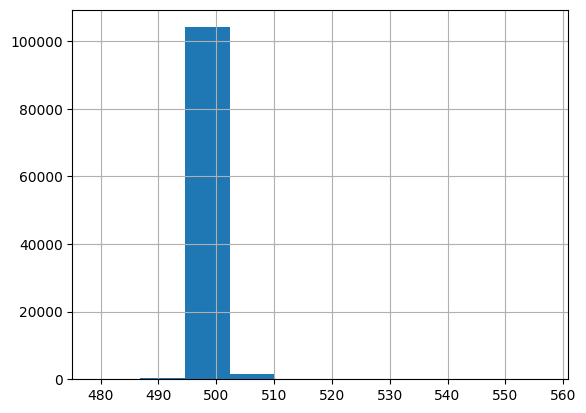

In [4]:
df.posts.str.split().str.len().hist()
print('average sentence length: ', df.posts.str.split().str.len().mean())
print('stdev sentence length: ', df.posts.str.split().str.len().std())

In [5]:
cols = df.columns
label_cols = list(cols[1:])
num_labels = len(label_cols)
print('Label columns: ', label_cols, num_labels)

Label columns:  ['IE', 'NS', 'TF', 'JP'] 4


In [6]:
# get count and indices of rows that have 1 in ie class and 0 in ns class
ie_ns_rows = df[(df['IE'] == 1) & (df['NS'] == 0)]
print(ie_ns_rows.shape)
# drop 50 000 of these rows from the dataset randomly
df = df.drop(ie_ns_rows.sample(50000).index)

(74485, 5)


In [7]:
print(f"Count of {label_encoders['IE'].inverse_transform([1])} in IE: ", df['IE'].sum())
print(f"Count of {label_encoders['IE'].inverse_transform([0])} in IE: ", df['IE'].eq(0).sum())
print("")
print(f"Count of {label_encoders['NS'].inverse_transform([1])} in NS: ", df['NS'].sum())
print(f"Count of {label_encoders['NS'].inverse_transform([0])} in NS: ", df['NS'].eq(0).sum())
print("")
print(f"Count of {label_encoders['TF'].inverse_transform([1])} in TF: ", df['TF'].sum())
print(f"Count of {label_encoders['TF'].inverse_transform([0])} in TF: ", df['TF'].eq(0).sum())
print("")
print(f"Count of {label_encoders['JP'].inverse_transform([1])} in JP: ", df['JP'].sum())
print(f"Count of {label_encoders['JP'].inverse_transform([0])} in JP: ", df['JP'].eq(0).sum())

Count of ['I'] in IE:  30677
Count of ['E'] in IE:  25390

Count of ['S'] in NS:  9201
Count of ['N'] in NS:  46866

Count of ['T'] in TF:  37272
Count of ['F'] in TF:  18795

Count of ['P'] in JP:  36796
Count of ['J'] in JP:  19271


In [8]:
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,posts,IE,NS,TF,JP,one_hot_labels
6,often men one put chance get burn otherwise no...,1,0,1,0,"[1, 0, 1, 0]"
18,eye close bitch half get sure cringeworthy bea...,1,0,1,0,"[1, 0, 1, 0]"
19,town state time weird hour away go family reun...,1,0,1,0,"[1, 0, 1, 0]"
23,yes right world horrible place people even kno...,1,0,1,0,"[1, 0, 1, 0]"
24,effective method complete intuition amble nati...,1,0,1,0,"[1, 0, 1, 0]"


In [9]:
labels = list(df.one_hot_labels.values)
text = list(df.posts.values)

In [10]:
train_text, test_text, train_labels, test_labels= train_test_split(text, labels, random_state=42, test_size=0.30)

In [11]:
test_text, val_text, test_labels, val_labels = train_test_split(test_text, test_labels, random_state=42, test_size=0.50)

In [12]:
len(train_text), len(val_text), len(test_text)

(39246, 8411, 8410)

In [13]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        if len(text) >= 1024:
            encoding = self.tokenizer(text, return_tensors='pt', truncation=True, max_length = 1024, padding='max_length')
        else:
            encoding = self.tokenizer(text, return_tensors='pt', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(),'token_type_ids': encoding['token_type_ids'].flatten() , 'attention_mask': encoding['attention_mask'].flatten(), 'labels': torch.tensor(label)}

In [14]:

batch_size = 4

In [15]:
checkpoint = "xlnet-base-cased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataset = TextClassificationDataset(train_text, train_labels, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)

validation_dataset = TextClassificationDataset(val_text, val_labels, tokenizer)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)

test_dataset = TextClassificationDataset(test_text, test_labels, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [16]:
batch = next(iter(train_dataloader))
print({k: v.shape for k, v in batch.items()})

{'input_ids': torch.Size([4, 1024]), 'token_type_ids': torch.Size([4, 1024]), 'attention_mask': torch.Size([4, 1024]), 'labels': torch.Size([4, 4])}


In [17]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels = 4, problem_type="multi_label_classification")

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
torch.cuda.is_available()

True

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [20]:
epochs = 2

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(model.parameters(), lr = 1e-5)    
total_steps = len(train_dataloader) * epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from tqdm.auto import tqdm
from tqdm import trange
import evaluate


train_loss_set = []
val_loss_set = []

progress_bar = tqdm(range(total_steps))

accuracy_metric = evaluate.load("accuracy")
best_val_loss = float('inf')
early_stopping_patience = 2

step = 0


for epoch_i in trange(epochs, desc="Epoch"):

  # Training
  
  model.train()

  tr_loss = 0 
  nb_tr_examples, nb_tr_steps = 0, 0
  
  for batch in train_dataloader:
    
    if step % 40 == 0 and not step == 0:            
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    step+=1
    
    batch = {k: v.to(device) for k, v in batch.items()}
    b_input_ids = batch['input_ids']
    b_token_types = batch['token_type_ids']
    b_input_mask = batch['attention_mask']
    b_labels = batch['labels']
    optimizer.zero_grad()

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=b_token_types, attention_mask=b_input_mask)
    logits = outputs[0]
    loss = loss_fn(logits.view(-1,num_labels), b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())    

    
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    progress_bar.update(1)
    
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  model.eval()

  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]
  val_loss = 0
  nb_val_steps, nb_val_examples = 0, 0

  # Predict
  for batch in validation_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    b_input_ids = batch['input_ids']
    b_token_types = batch['token_type_ids']
    b_input_mask = batch['attention_mask']
    b_labels = batch['labels']
    
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=b_token_types, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      loss = loss_fn(outs[0].view(-1,num_labels), b_labels.type_as(outs[0]).view(-1,num_labels)) #convert labels to float for calculation
      val_loss_set.append(loss.item())

      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)
      predictions = (pred_label >= 0.5).int().reshape(-1)
    
      accuracy_metric.add_batch(predictions=predictions, references=b_labels.int().reshape(-1))

      # b_logit_pred = b_logit_pred.detach().cpu().numpy()
      # pred_label = pred_label.to('cpu').numpy()
      # b_labels = b_labels.to('cpu').numpy() 

    val_loss += loss.item()
    nb_val_examples += b_input_ids.size(0)
    nb_val_steps += 1

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)
  
  print("Validation loss: {}".format(val_loss/nb_val_steps))

  # # Flatten outputs
  # pred_labels = [item for sublist in pred_labels for item in sublist]
  # true_labels = [item for sublist in true_labels for item in sublist]

  # # Calculate Accuracy
  # threshold = 0.50
  # pred_bools = [pl>threshold for pl in pred_labels]
  # true_bools = [tl==1 for tl in true_labels]
  # val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  # val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100
  avg_val_loss = val_loss/nb_val_steps
  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    epochs_without_improvement = 0
    # Save the best model
    print("saved a model")
    torch.save(model.state_dict(), "/kaggle/working/mbti-500-classifier-model.pth")
  else:
    epochs_without_improvement += 1
    if epochs_without_improvement >= early_stopping_patience:
      print(f'Early stopping triggered after {epoch_i} epochs without improvement.')
      break

  val_flat_accuracy = accuracy_metric.compute()

  # print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Validation Accuracy: ', val_flat_accuracy)

  0%|          | 0/19624 [00:00<?, ?it/s]


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  Batch    40  of  9,812.
  Batch    80  of  9,812.
  Batch   120  of  9,812.
  Batch   160  of  9,812.
  Batch   200  of  9,812.
  Batch   240  of  9,812.
  Batch   280  of  9,812.
  Batch   320  of  9,812.
  Batch   360  of  9,812.
  Batch   400  of  9,812.
  Batch   440  of  9,812.
  Batch   480  of  9,812.
  Batch   520  of  9,812.
  Batch   560  of  9,812.
  Batch   600  of  9,812.
  Batch   640  of  9,812.
  Batch   680  of  9,812.
  Batch   720  of  9,812.
  Batch   760  of  9,812.
  Batch   800  of  9,812.
  Batch   840  of  9,812.
  Batch   880  of  9,812.
  Batch   920  of  9,812.
  Batch   960  of  9,812.
  Batch 1,000  of  9,812.
  Batch 1,040  of  9,812.
  Batch 1,080  of  9,812.
  Batch 1,120  of  9,812.
  Batch 1,160  of  9,812.
  Batch 1,200  of  9,812.
  Batch 1,240  of  9,812.
  Batch 1,280  of  9,812.
  Batch 1,320  of  9,812.
  Batch 1,360  of  9,812.
  Batch 1,400  of  9,812.
  Batch 1,440  of  9,812.
  Batch 1,480  of  9,812.
  Batch 1,520  of  9,812.
  Batch 1,56


Epoch:  50%|█████     | 1/2 [3:49:00<3:49:00, 13740.36s/it]

Validation Accuracy:  {'accuracy': 0.9330341219831173}
  Batch 9,840  of  9,812.
  Batch 9,880  of  9,812.
  Batch 9,920  of  9,812.
  Batch 9,960  of  9,812.
  Batch 10,000  of  9,812.
  Batch 10,040  of  9,812.
  Batch 10,080  of  9,812.
  Batch 10,120  of  9,812.
  Batch 10,160  of  9,812.
  Batch 10,200  of  9,812.
  Batch 10,240  of  9,812.
  Batch 10,280  of  9,812.
  Batch 10,320  of  9,812.
  Batch 10,360  of  9,812.
  Batch 10,400  of  9,812.
  Batch 10,440  of  9,812.
  Batch 10,480  of  9,812.
  Batch 10,520  of  9,812.
  Batch 10,560  of  9,812.
  Batch 10,600  of  9,812.
  Batch 10,640  of  9,812.
  Batch 10,680  of  9,812.
  Batch 10,720  of  9,812.
  Batch 10,760  of  9,812.
  Batch 10,800  of  9,812.
  Batch 10,840  of  9,812.
  Batch 10,880  of  9,812.
  Batch 10,920  of  9,812.
  Batch 10,960  of  9,812.
  Batch 11,000  of  9,812.
  Batch 11,040  of  9,812.
  Batch 11,080  of  9,812.
  Batch 11,120  of  9,812.
  Batch 11,160  of  9,812.
  Batch 11,200  of  9,812.
  Ba


Epoch: 100%|██████████| 2/2 [7:38:29<00:00, 13754.56s/it]

Validation Accuracy:  {'accuracy': 0.9415646177624539}


In [22]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    b_input_ids = batch['input_ids']
    b_token_types = batch['token_type_ids']
    b_input_mask = batch['attention_mask']
    b_labels = batch['labels']
    with torch.no_grad():
        outs = model(b_input_ids, token_type_ids=b_token_types, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)
    predictions = (pred_label >= 0.5).int().reshape(-1)
    
    accuracy_metric.add_batch(predictions=predictions, references=b_labels.int().reshape(-1))

accuracy_metric.compute()

{'accuracy': 0.9392390011890607}

In [23]:
# torch.save(model.state_dict(), "/kaggle/working/XLNet_classifier.pth")